In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [43]:
sales = pd.read_excel('sales.xlsx')
sales

,CustomerID,Date_Adherence,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Complain
0,11054,2021-03-18 00:00:00,85.0,7230.0,1820,3435.0,1600.0,440.0,57.0,1,13,4,13,6,0
1,17117,2021-03-01 00:00:00,96.0,5850.0,320,2745.0,500.0,320.0,8.0,3,9,7,9,6,0
2,31751,2021-11-01 00:00:00,7.0,8380.0,0,1560.0,0.0,0.0,28.0,3,9,5,3,9,0
3,12947,2022-05-19 00:00:00,54.0,5090.0,280,2355.0,140.0,560.0,78.0,3,7,5,11,3,0
4,11402,2021-01-01 00:00:00,64.0,330.0,0,240.0,0.0,0.0,7.0,2,4,1,3,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,23699,2021-11-27 00:00:00,54.0,290.0,20,180.0,0.0,40.0,4.0,2,4,1,4,7,0
7004,23255,2021-03-25 00:00:00,27.0,230.0,80,525.0,20.0,80.0,23.0,3,5,1,3,8,0
7005,5798,2022-04-12 00:00:00,36.0,3050.0,2460,3840.0,1800.0,980.0,107.0,1,8,4,13,4,0
7006,16577,2020-09-01 00:00:00,49.0,20.0,200,90.0,160.0,0.0,14.0,1,3,2,2,8,1


In [44]:
sales.set_index ('CustomerID', inplace = True)

In [45]:
#check for duplicates 
#sales [sales.duplicated()]
sales.drop_duplicates(inplace= True)

In [46]:
sales.shape

(7000, 14)

In [47]:
#Impute MntDrinks

sales_products = sales[['MntDrinks','MntDesserts','MntEntries','MntVegan&Vegetarian']] # we are using this variables to impute in drinks because they have a corr>0.7

imputer = KNNImputer(n_neighbors=1)
array_impute = imputer.fit_transform(sales_products) # this is an array
sales_products = pd.DataFrame(array_impute, columns = sales_products.columns)

sales['MntDrinks'] = sales_products['MntDrinks'].values

In [48]:
#Input recency com a média
sales.fillna({'Recency': sales['Recency'].mean}, inplace = True)

In [49]:
#sales.isna().sum()

INFO : 6 float variables; 8 integer variables; 1 object variable

In [50]:
#recency está em object tem de passar para integer
#sales["Recency"] = sales["Recency"].astype(str).astype(float)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 11054 to 25310
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date_Adherence         7000 non-null   object 
 1   Recency                7000 non-null   object 
 2   MntMeat&Fish           7000 non-null   float64
 3   MntEntries             7000 non-null   int64  
 4   MntVegan&Vegetarian    7000 non-null   float64
 5   MntDrinks              7000 non-null   float64
 6   MntDesserts            7000 non-null   float64
 7   MntAdditionalRequests  7000 non-null   float64
 8   NumOfferPurchases      7000 non-null   int64  
 9   NumAppPurchases        7000 non-null   int64  
 10  NumTakeAwayPurchases   7000 non-null   int64  
 11  NumStorePurchases      7000 non-null   int64  
 12  NumAppVisitsMonth      7000 non-null   int64  
 13  Complain               7000 non-null   int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 82

## Outliers

In [51]:
#sales.hist(sales['Recency'])
#sns.histplot(data = sales, x = 'Recency', color="g", bins = 10)

## Clusters - Perspectiva preferência pela via de consumo (APP,TK AWAY, STORE)

Identify the right number of clusters

In [52]:
#Criar subset com as variáveis que vão contribuir para os clusters
sales_vc = sales[[ 'NumAppPurchases','NumTakeAwayPurchases', 'NumStorePurchases',]].copy()
sales_vc

,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases
CustomerID,,,
11054,13,4,13
17117,9,7,9
31751,9,5,3
12947,7,5,11
11402,4,1,3
...,...,...,...
23699,4,1,4
23255,5,1,3
5798,8,4,13


In [85]:
from scipy.stats import mode

In [90]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [91]:
from kmodes.kmodes import KModes

In [54]:
ks = range(1, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k).fit(sales_vc)
    inertias.append(model.inertia_)

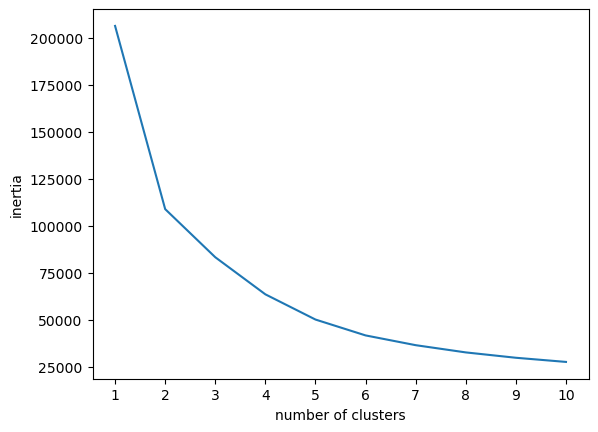

In [55]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for the x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for the y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks on the x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

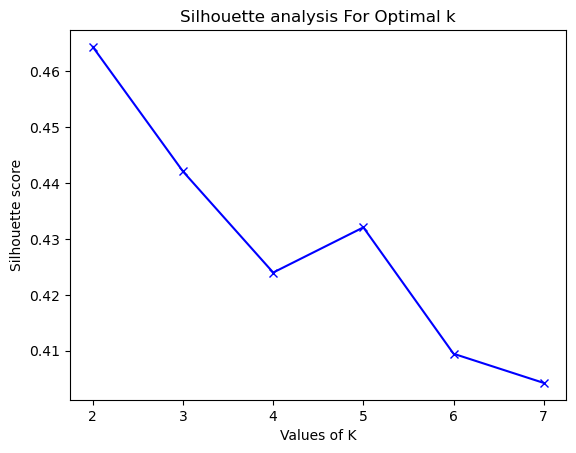

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6, 7]
silhouette_avg = []
for num_clusters in range_n_clusters:

    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(sales_vc)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(sales_vc, cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The optimal K with the Silhouette method is 2! 

The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation). 
https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

Testar K= 2; 3; 5 

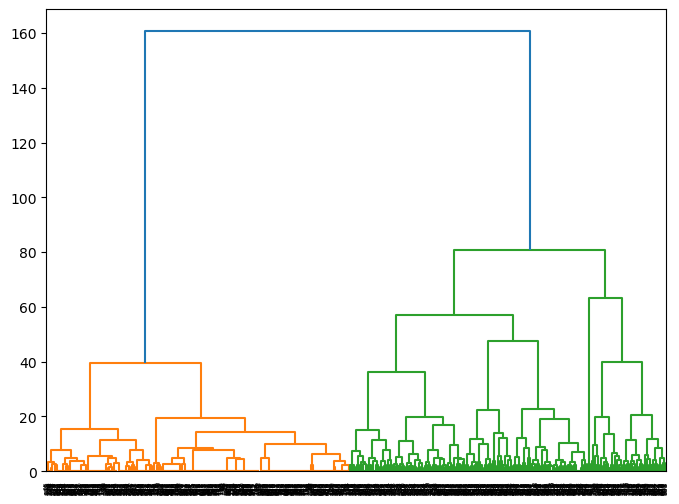

In [57]:
    from scipy.cluster import hierarchy
#from sklearn.cluster import AgglomerativeClustering - The option available in sklearn

# Get a random sample, as hierarchical clustering can take a lot of time to run.
sales_vc_sample = sales_vc.sample(n = 1000, random_state = 100)

# create clusters using the "ward method"
clusters = hierarchy.linkage(sales_vc_sample , method="ward")

# create the dendrogram using the hierarchy.dendrogram() method.
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

## 2 Clusters (K=2)

In [58]:
sales_vc_k2 = sales_vc.copy()
model_k2 = KMeans(n_clusters=2, random_state = 100).fit(sales_vc_k2)

In [59]:
sales_vc_k2['k_label'] = model_k2.labels_

In [60]:
sales_vc_k2.groupby(['k_label']).mean().transpose()

k_label,0,1
NumAppPurchases,4.311242,7.795853
NumTakeAwayPurchases,1.693512,6.070678
NumStorePurchases,3.372763,8.315713


In [61]:
sales_vc_k2.groupby(['k_label']).describe().transpose()

k_label                               0            1
NumAppPurchases      count  3576.000000  3424.000000
                     mean      4.311242     7.795853
                     std       1.645387     2.525956
                     min       0.000000     0.000000
                     25%       3.000000     6.000000
                     50%       4.000000     8.000000
                     75%       5.000000    10.000000
                     max      11.000000    13.000000
NumTakeAwayPurchases count  3576.000000  3424.000000
                     mean      1.693512     6.070678
                     std       0.961655     3.454343
                     min       0.000000     2.000000
                     25%       1.000000     4.000000
                     50%       1.000000     5.000000
                     75%       2.000000     8.000000
                     max       7.000000    24.000000
NumStorePurchases    count  3576.000000  3424.000000
                     mean      3.372763     8.315713
                     std       1.282928     2.829239
                     min       0.000000     0.000000
                     25%       3.000000     6.000000
                     50%       3.000000     8.000000
                     75%       4.000000    11.000000
                     max       8.000000    13.000000

## 3 Clusters (K=3) 

In [62]:
sales_vc_k3 = sales_vc.copy()
model_k3 = KMeans(n_clusters=3, random_state = 100).fit(sales_vc_k3)

In [63]:
sales_vc_k3['k_label'] = model_k3.labels_

In [64]:
sales_vc_k3.groupby(['k_label']).mean().transpose()

k_label,0,1,2
NumAppPurchases,8.305284,4.137574,6.483568
NumTakeAwayPurchases,4.243836,1.653254,9.775587
NumStorePurchases,8.486106,3.237278,7.427230


Ordem de grandeza do clusters (n.º de individuos) : 2 < 0 < 1 

- C0 compra mais na app e na loja (grupo de clientes regulares)
- C1 é o que tem mais gentes mas o que consome menos (clientes não regulares)
- C2 compra mais no TK Away, mas o cluster que consome mais no geral (grupo de clientes regulares que previligiam o TK Away)


In [65]:
descr = sales_vc_k3.groupby(['k_label']).describe().transpose()
descr

k_label                               0            1            2
NumAppPurchases      count  2555.000000  3380.000000  1065.000000
                     mean      8.305284     4.137574     6.483568
                     std       2.328695     1.474959     2.376254
                     min       3.000000     0.000000     0.000000
                     25%       7.000000     3.000000     5.000000
                     50%       8.000000     4.000000     6.000000
                     75%      10.000000     5.000000     8.000000
                     max      13.000000    11.000000    13.000000
NumTakeAwayPurchases count  2555.000000  3380.000000  1065.000000
                     mean      4.243836     1.653254     9.775587
                     std       1.544573     0.959310     3.673898
                     min       1.000000     0.000000     6.000000
                     25%       3.000000     1.000000     8.000000
                     50%       4.000000     1.000000     9.000000
                     75%       5.000000     2.000000    11.000000
                     max       9.000000     7.000000    24.000000
NumStorePurchases    count  2555.000000  3380.000000  1065.000000
                     mean      8.486106     3.237278     7.427230
                     std       2.545456     1.148065     3.297101
                     min       3.000000     0.000000     0.000000
                     25%       6.000000     3.000000     5.000000
                     50%       8.000000     3.000000     7.000000
                     75%      10.000000     4.000000    10.000000
                     max      13.000000     8.000000    13.000000

## 5 Clusters (K=5) 

In [66]:
sales_vc_k5 = sales_vc.copy()
model_k5 = KMeans(n_clusters=5, random_state = 100).fit(sales_vc_k5)

In [67]:
sales_vc_k5['k_label'] = model_k5.labels_

In [68]:
sales_vc_k5.groupby(['k_label']).mean().transpose()

k_label,0,1,2,3,4
NumAppPurchases,8.132075,6.936830,3.824180,0.491803,7.778755
NumTakeAwayPurchases,3.391652,8.637664,1.483590,23.213115,5.726740
NumStorePurchases,6.282447,6.343266,3.038513,0.409836,11.081319


Ordem de grandeza do clusters (n.º de individuos) : 4 > 0 > 3 > 1 > 2

- C0 (geral_avg=17) consome mais na APP 
- C1 (geral_avg=20) consome mais no TK Away, mas não é o que consome mais
- C2 (geral_avg=24) consome maioritariamente TK Away (praticamente só Tk Away e nada na app e loja) grupo de clientes regulares que previligiam o TK Away, "habituais"); A mediana é =0 para a compra na APP e na Loja
- C3 (geral_avg=24) preferencia pelo com sumo na loja
- c4 o que consome menos e o que tem mais individuos, é o que consome menos Tk Away (os cliente menos regulares, i.e a maioria)

In [69]:
sales_vc_k5.groupby(['k_label']).describe().transpose()

k_label                               0           1            2          3  \
NumAppPurchases      count  1749.000000  839.000000  2986.000000  61.000000   
                     mean      8.132075    6.936830     3.824180   0.491803   
                     std       2.205217    1.950966     1.198644   0.504082   
                     min       3.000000    3.000000     0.000000   0.000000   
                     25%       7.000000    6.000000     3.000000   0.000000   
                     50%       8.000000    7.000000     4.000000   0.000000   
                     75%      10.000000    8.000000     5.000000   1.000000   
                     max      13.000000   13.000000     7.000000   1.000000   
NumTakeAwayPurchases count  1749.000000  839.000000  2986.000000  61.000000   
                     mean      3.391652    8.637664     1.483590  23.213115   
                     std       1.230969    1.871100     0.771280   0.412907   
                     min       1.000000    6.000000     0.000000  23.000000   
                     25%       2.000000    7.000000     1.000000  23.000000   
                     50%       3.000000    8.000000     1.000000  23.000000   
                     75%       4.000000   10.000000     2.000000  23.000000   
                     max       7.000000   12.000000     6.000000  24.000000   
NumStorePurchases    count  1749.000000  839.000000  2986.000000  61.000000   
                     mean      6.282447    6.343266     3.038513   0.409836   
                     std       1.574698    1.924326     0.995900   0.495885   
                     min       2.000000    3.000000     0.000000   0.000000   
                     25%       5.000000    5.000000     3.000000   0.000000   
                     50%       6.000000    6.000000     3.000000   0.000000   
                     75%       8.000000    8.000000     4.000000   1.000000   
                     max       9.000000   11.000000     8.000000   1.000000   

k_label                               4  
NumAppPurchases      count  1365.000000  
                     mean      7.778755  
                     std       2.387219  
                     min       3.000000  
                     25%       6.000000  
                     50%       7.000000  
                     75%       9.000000  
                     max      13.000000  
NumTakeAwayPurchases count  1365.000000  
                     mean      5.726740  
                     std       2.148974  
                     min       3.000000  
                     25%       4.000000  
                     50%       6.000000  
                     75%       7.000000  
                     max      12.000000  
NumStorePurchases    count  1365.000000  
                     mean     11.081319  
                     std       1.309220  
                     min       8.000000  
                     25%      10.000000  
                     50%      11.000000  
                     75%      12.000000  
                     max      13.000000

## 4 Clusters (K=4) --> SOLUÇÃO

In [70]:
sales_vc_k4 = sales_vc.copy()
model_k4 = KMeans(n_clusters=4, random_state = 100).fit(sales_vc_k4)

In [71]:
sales_vc_k4['k_label'] = model_k4.labels_

In [72]:
sales_vc_k4.groupby(['k_label']).mean().transpose()

k_label,0,1,2,3
NumAppPurchases,8.034247,7.502709,3.893459,0.491803
NumTakeAwayPurchases,4.689954,6.337146,1.499028,23.213115
NumStorePurchases,6.050685,10.618302,3.115609,0.409836


Ordem de grandeza do clusters (n.º de individuos) : 3 < 2 < 1 < 0

- C0 (geral_avg~8)  APP e Loja está mais equilibrado e que menos consome TK Away; é o grupo que tem mais individuos (Menos regulares)
- C1 (geral_avg~19) Consome mais na APP
- C2 (geral_avg~24) consome mais na loja, é o que consome mais na loja, são clientes regulares
- C3 (geral_avg=24) consome maioritariamente TK Away (praticamente só Tk Away e nada na app e loja) grupo de clientes regulares que previligiam o TK Away, "habituais"); A mediana é =0 para a compra na APP e na Loja


In [73]:
sales_vc_k4.groupby(['k_label']).describe().transpose()

k_label                               0            1            2          3
NumAppPurchases      count  2190.000000  1661.000000  3088.000000  61.000000
                     mean      8.034247     7.502709     3.893459   0.491803
                     std       2.199966     2.321876     1.251361   0.504082
                     min       4.000000     3.000000     0.000000   0.000000
                     25%       6.000000     6.000000     3.000000   0.000000
                     50%       8.000000     7.000000     4.000000   0.000000
                     75%      10.000000     9.000000     5.000000   1.000000
                     max      13.000000    13.000000     7.000000   1.000000
NumTakeAwayPurchases count  2190.000000  1661.000000  3088.000000  61.000000
                     mean      4.689954     6.337146     1.499028  23.213115
                     std       2.476060     2.540183     0.756357   0.412907
                     min       1.000000     3.000000     0.000000  23.000000
                     25%       3.000000     4.000000     1.000000  23.000000
                     50%       4.000000     6.000000     1.000000  23.000000
                     75%       6.000000     8.000000     2.000000  23.000000
                     max      12.000000    12.000000     7.000000  24.000000
NumStorePurchases    count  2190.000000  1661.000000  3088.000000  61.000000
                     mean      6.050685    10.618302     3.115609   0.409836
                     std       1.546799     1.620651     1.092681   0.495885
                     min       2.000000     6.000000     0.000000   0.000000
                     25%       5.000000     9.000000     3.000000   0.000000
                     50%       6.000000    11.000000     3.000000   0.000000
                     75%       7.000000    12.000000     4.000000   1.000000
                     max       9.000000    13.000000     8.000000   1.000000

## Visualização

HISTOGRAMAS

In [74]:
cluster0 = sales_vc_k4[sales_vc_k4.k_label==0]
cluster1 = sales_vc_k4[sales_vc_k4.k_label==1]
cluster2 = sales_vc_k4[sales_vc_k4.k_label==2]
cluster3 = sales_vc_k4[sales_vc_k4.k_label==3]

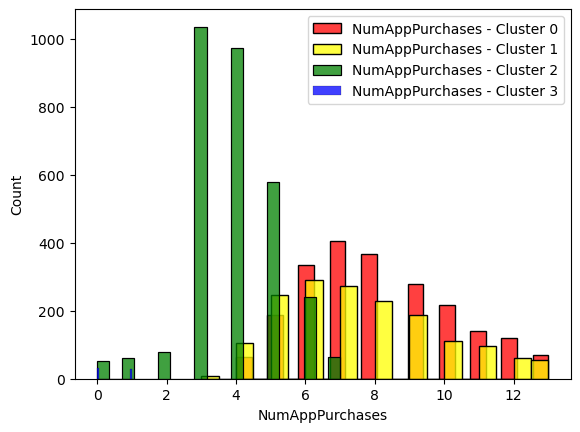

In [75]:
sns.histplot(cluster0['NumAppPurchases'],color='red',label='NumAppPurchases - Cluster 0', bins = 20)
sns.histplot(cluster1['NumAppPurchases'],color='yellow',label='NumAppPurchases - Cluster 1', bins = 20)
sns.histplot(cluster2['NumAppPurchases'],color='green',label='NumAppPurchases - Cluster 2', bins = 20)
sns.histplot(cluster3['NumAppPurchases'],color='blue',label='NumAppPurchases - Cluster 3', bins = 20)
plt.legend()

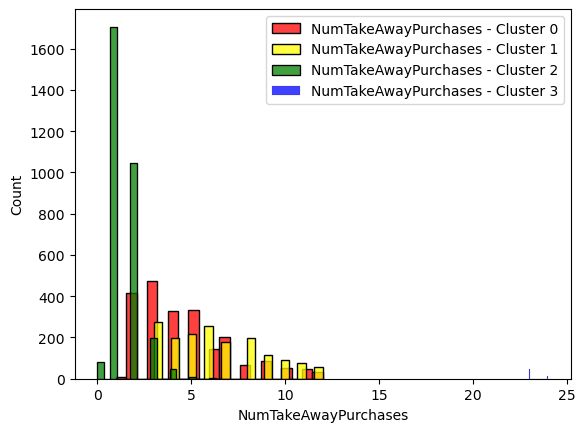

In [76]:
sns.histplot(cluster0['NumTakeAwayPurchases'],color='red',label='NumTakeAwayPurchases - Cluster 0', bins = 20)
sns.histplot(cluster1['NumTakeAwayPurchases'],color='yellow',label='NumTakeAwayPurchases - Cluster 1', bins = 20)
sns.histplot(cluster2['NumTakeAwayPurchases'],color='green',label='NumTakeAwayPurchases - Cluster 2', bins = 20)
sns.histplot(cluster3['NumTakeAwayPurchases'],color='blue',label='NumTakeAwayPurchases - Cluster 3', bins = 20)
plt.legend()

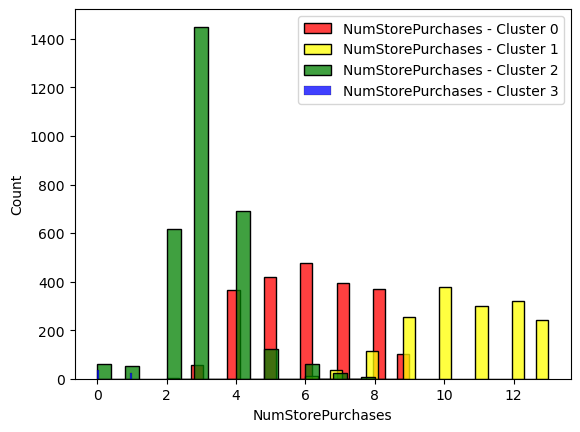

In [77]:
sns.histplot(cluster0['NumStorePurchases'],color='red',label='NumStorePurchases - Cluster 0', bins = 20)
sns.histplot(cluster1['NumStorePurchases'],color='yellow',label='NumStorePurchases - Cluster 1', bins = 20)
sns.histplot(cluster2['NumStorePurchases'],color='green',label='NumStorePurchases - Cluster 2', bins = 20)
sns.histplot(cluster3['NumStorePurchases'],color='blue',label='NumStorePurchases - Cluster 3', bins = 20)
plt.legend()

SCATTER PLOT

In [78]:
centroids = model_k4.cluster_centers_
centroids

array([[ 8.03424658,  4.68995434,  6.05068493],
       [ 7.50270921,  6.3371463 , 10.61830223],
       [ 3.89345855,  1.4990285 ,  3.11560881],
       [ 0.49180328, 23.21311475,  0.40983607]])

In [79]:
sales_vc.columns

Index(['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases'], dtype='object')

In [80]:
centroid_0_APP = centroids[0,0]
centroid_1_APP = centroids[1,0]
centroid_2_APP = centroids[2,0]
centroid_3_APP = centroids[3,0]
centroid_0_STORE = centroids[0,1]
centroid_1_STORE = centroids[1,1]
centroid_2_STORE = centroids[2,1]
centroid_3_STORE = centroids[3,1]
centroid_0_TKAWAY = centroids[0,2]
centroid_1_TKAWAY = centroids[1,2]
centroid_2_TKAWAY = centroids[2,2]
centroid_3_TKAWAY = centroids[3,2]

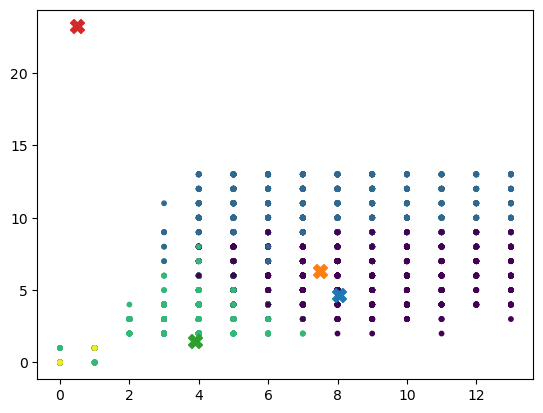

In [81]:
plt.scatter(sales_vc_k4.NumAppPurchases, sales_vc_k4.NumStorePurchases,
            c=sales_vc_k4.k_label, s=10)

plt.scatter(centroid_0_APP, centroid_0_STORE, marker='X', s=100)
plt.scatter(centroid_1_APP, centroid_1_STORE, marker='X', s=100)
plt.scatter(centroid_2_APP, centroid_2_STORE, marker='X', s=100)
plt.scatter(centroid_3_APP, centroid_3_STORE, marker='X', s=100)

plt.show()

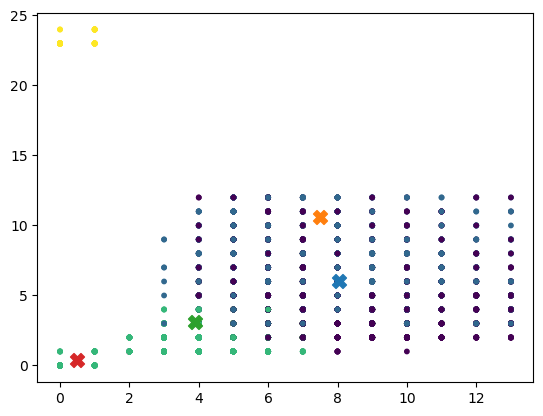

In [82]:
plt.scatter(sales_vc_k4.NumAppPurchases, sales_vc_k4.NumTakeAwayPurchases,
            c=sales_vc_k4.k_label, s=10)

plt.scatter(centroid_0_APP, centroid_0_TKAWAY, marker='X', s=100)
plt.scatter(centroid_1_APP, centroid_1_TKAWAY, marker='X', s=100)
plt.scatter(centroid_2_APP, centroid_2_TKAWAY, marker='X', s=100)
plt.scatter(centroid_3_APP, centroid_3_TKAWAY, marker='X', s=100)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

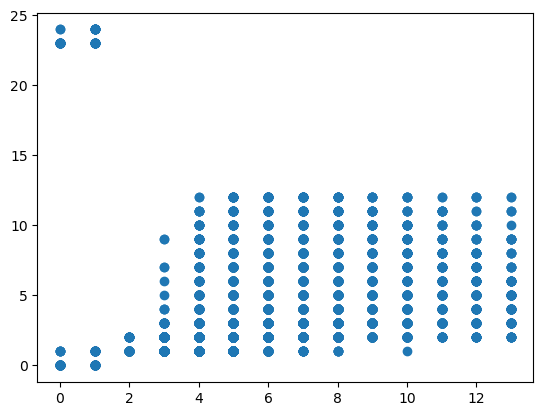

In [83]:
plt.scatter(sales["NumAppPurchases"], sales["NumTakeAwayPurchases"])
plt.show

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### DBSCAN clustering 
    
</div>

Ran the code of this site: https://www.reneshbedre.com/blog/dbscan-python.html?utm_content=cmp-true

In [97]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 5).fit(sales_vc)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(sales_vc)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

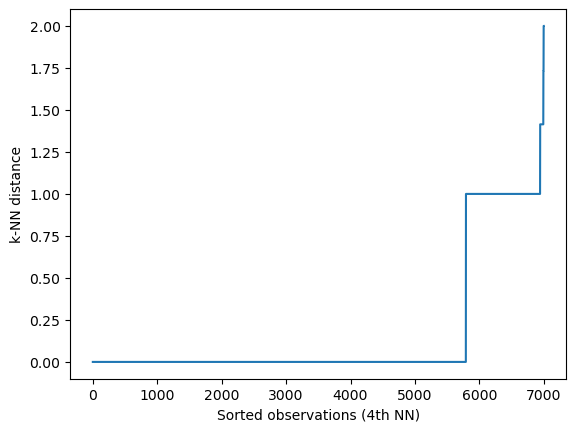

In [98]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()


- Identifying the exact knee point could be difficult visually. In the below plot, the knee point can occur at any point between 1 to 2 i.e. the points below knee point belong to a cluster, and points above the knee point are noise or outliers (noise points will have higher kNN distance). You should run DBSCAN based on different values of ε (between 1 and 2) to find the best ε that gives the best clustering.

- Additionally, to get an estimate of knee point, you can use the KneeLocator() function from the kneed package.

In [100]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [101]:
from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

2.0


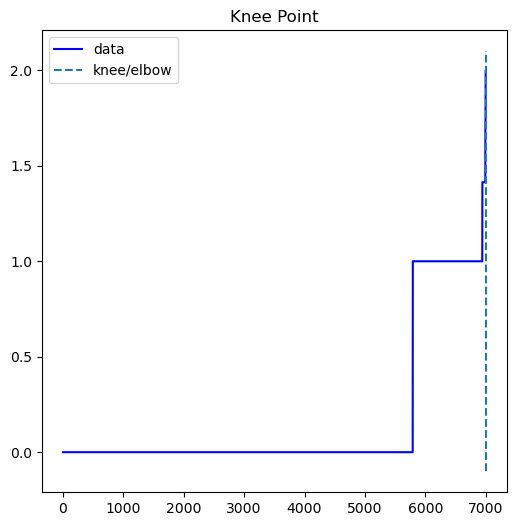

In [102]:
#distance plot
kneedle.plot_knee()
plt.show()

In [120]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps = 2, min_samples = 1).fit(sales_vc)

In [121]:
# get cluster labels
clusters.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [122]:
# check unique clusters
set(clusters.labels_)

{0, 1}

In [123]:
from collections import Counter
Counter(clusters.labels_)

Counter({0: 6939, 1: 61})

Visualization of DBSCAN clustering

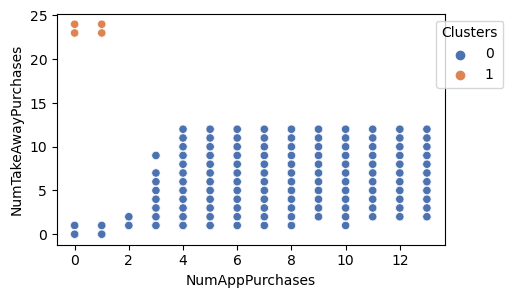

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
p = sns.scatterplot(data = sales_vc, x = "NumAppPurchases", y = "NumTakeAwayPurchases", hue = clusters.labels_, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.show()

## ran the code of this site: https://www.section.io/engineering-education/dbscan-clustering-in-python/

In [118]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(sales_vc) # fitting the data to the object
distances,indices=nbrs.kneighbors(sales_vc) # finding the nearest neighbours

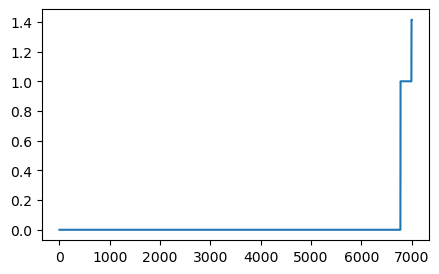

In [119]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot


<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### Fuzzy clustering 
    
</div>

In [93]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 9.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894075 sha256=8d97763ae1f14d2bd7ae82fd6d9b9378bdc882f9500212e4963caec710d16177
  Stored in directory: /Users/jp/Library/Caches/pip/wheels/32/2c/a1/a90a7d7dd8448ec029f298a61f3490275e99b17aa348be675c
Successfully built scikit-fuzzy
Note: you may need to restart the kernel to use updated packages.


In [94]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz